## **Classez des images**

### partie 1/4 : analyse et prétraitement des images

<br>

> #### notebook contenant l'analyse et le prétraitement d'images (e.g. whitening, equalization, modification de la taille des images). <br><br>

<br>


## 0 Imports


### 0.1 Librairies, réglages


In [1]:
# paths, folders/files
import os, sys, random
from os import listdir
from glob import glob
from zipfile import ZipFile

# math, dataframes
import numpy as np
import pandas as pd
from pandarallel import pandarallel
from collections import Counter

# Visualisation
from pprint import pprint
import matplotlib.pyplot as plt
from matplotlib.image import imread
import seaborn as sns
import plotly.express as px
# from wordcloud import WordCloud
from PIL import Image

# NLP
# from bs4 import BeautifulSoup
import re, string
import nltk
# nltk.download('punkt')
# nltk.download('stopwords')
# from nltk.stem import WordNetLemmatizer
# from nltk.corpus import wordnet
# nltk.download('wordnet')
# nltk.download('averaged_perceptron_tagger')

# Feature engineering
from sklearn import preprocessing
from sklearn import manifold, decomposition
from sklearn import cluster, metrics
# from sklearn.model_selection import train_test_split
# from sklearn.feature_extraction.text import CountVectorizer

# NN
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, GlobalAveragePooling1D, Flatten, Dense, Dropout
from tensorflow.keras.layers import Rescaling, RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical

print('\nPython version ' + sys.version)
print('pandas version ' + pd.__version__)

# plt.style.use('ggplot')
pd.set_option('display.max_rows', 200)

# Modify if necessary
num_cores = os.cpu_count()
print(f"\nNumber of CPU cores: {num_cores}")
pandarallel.initialize(progress_bar=False, nb_workers=6)


2024-03-24 10:55:24.568606: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.



Python version 3.11.5 (main, Sep 11 2023, 13:23:44) [GCC 11.2.0]
pandas version 2.2.1

Number of CPU cores: 8
INFO: Pandarallel will run on 6 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


### 0.2 Fonctions


In [2]:
# Principalement des fonctions pour l'affichage des graphiques pdt l'EDA

def quick_look(df, miss=True):
    """
    Display a quick overview of a DataFrame, including shape, head, tail, unique values, and duplicates.

    Args:
        df (pandas.DataFrame): The input DataFrame to inspect.
        check_missing (bool, optional): Whether to check and display missing values (default is True).

    The function provides a summary of the DataFrame, including its shape, the first and last rows, the count of unique values per column, and the number of duplicates.
    If `check_missing` is set to True, it also displays missing value information.
    """
    print(f'shape : {df.shape}')

    display(df.head())
    display(df.tail())

    print('uniques :')
    display(df.nunique())

    print('Doublons ? ', df.duplicated(keep='first').sum(), '\n')

    if miss:
        display(get_missing_values(df))


def lerp(a, b, t):
    """
    Linear interpolation between two values 'a' and 'b' at a parameter 't'.
    A very useful little function, used here to position annotations in plots.
    Got it coding with Radu :)

    Given two values 'a' and 'b', and a parameter 't',
    this function calculates the linear interpolation between 'a' and 'b' at 't'.

    Parameters:
    a (float or int): The start value.
    b (float or int): The end value.
    t (float): The interpolation parameter (typically in the range [0, 1], but can be outside).

    Returns:
    float or int: The interpolated value at parameter 't'.
    """
    return a + (b - a) * t


def generate_random_pastel_colors(n):
    """
    Generates a list of n random pastel colors, represented as RGBA tuples.

    Parameters:
    n (int): The number of pastel colors to generate.

    Returns:
    list: A list of RGBA tuples representing random pastel colors.

    Example:
    >>> generate_random_pastel_colors(2)
    [(0.749, 0.827, 0.886, 1.0), (0.886, 0.749, 0.827, 1.0)]
    """
    colors = []
    for _ in range(n):
        # Generate random pastels
        red = round(random.randint(150, 250) / 255.0, 3)
        green = round(random.randint(150, 250) / 255.0, 3)
        blue = round(random.randint(150, 250) / 255.0, 3)

        # Create an RGB color tuple and add it to the list
        color = (red,green,blue, 1.0)
        colors.append(color)

    return colors

print(generate_random_pastel_colors(2))


def get_missing_values(df):
    """Generates a DataFrame containing the count and proportion of missing values for each feature.

    Args:
        df (pandas.DataFrame): The input DataFrame to analyze.

    Returns:
        pandas.DataFrame: A DataFrame with columns for the feature name, count of missing values,
        count of non-missing values, proportion of missing values, and data type for each feature.
    """
    # Count the missing values for each column
    missing = df.isna().sum()

    # Calculate the percentage of missing values
    percent_missing = df.isna().mean() * 100

    # Create a DataFrame to store the results
    missings_df = pd.DataFrame({
        'column_name': df.columns,
        'missing': missing,
        'present': df.shape[0] - missing,  # Count of non-missing values
        'percent_missing': percent_missing.round(2),  # Rounded to 2 decimal places
        'type': df.dtypes
    })

    # Sort the DataFrame by the count of missing values
    missings_df.sort_values('missing', inplace=True)

    return missings_df

# with pd.option_context('display.max_rows', 1000):
#   display(get_missing_values(df))


def hist_distrib(dataframe, feature, bins, decimal_places, density=True):
    """
    Visualize the empirical distribution of a numerical feature using a histogram.
    Calcul des principaux indicateurs de tendance centrale, dispersion et forme.

    Args:
        dataframe (pandas.DataFrame): The input DataFrame containing the feature.
        feature (str): The name of the numerical feature to visualize.
        bins (int): The number of bins for the histogram.
        decimal_places (int): The number of decimal places for rounding numeric values.
        density (bool, optional): Whether to display the histogram as a density plot (default is True).

    Returns:
        float: The skewness of the feature's distribution.

    The function generates a histogram of the feature, displays various statistics, and returns the skewness of the distribution.
    """
    # Calculate central tendencies and dispersion
    mode_value = round(dataframe[feature].mode()[0], decimal_places)
    mode_non_zero = "N/A"
    if (dataframe[feature] != 0).any():
        mode_non_zero = round(dataframe.loc[dataframe[feature] != 0, feature].mode()[0], decimal_places)
    median_value = round(dataframe[feature].median(), decimal_places)
    mean_value = round(dataframe[feature].mean(), decimal_places)

    # Calculate dispersion
    var_emp = round(dataframe[feature].var(ddof=0), decimal_places)
    coeff_var = round(dataframe[feature].std(ddof=0), decimal_places)

    # Calculate shape indicators
    skewness_value = round(dataframe[feature].skew(), 2)
    kurtosis_value = round(dataframe[feature].kurtosis(), 2)

    # Create the plot
    fig, ax = plt.subplots(figsize=(12, 5))
    dataframe[feature].hist(density=density, bins=bins, color='#7cf', ax=ax, rwidth=0.9)

    # Adjust placement for annotations
    yt = plt.yticks()
    y_position = lerp(yt[0][0], yt[0][-1], 0.8)
    y_increment = y_position / 20
    xt = plt.xticks()
    x_position = lerp(xt[0][0], xt[0][-1], 0.7)

    # Add annotations with horizontal and vertical alignment
    annotation_fs = 13
    color = 'g'
    ax.annotate(f'Mode: {mode_value}', xy=(x_position, y_position), fontsize=annotation_fs,
                xytext=(x_position, y_position), color=color, ha='left', va='bottom')
    ax.annotate(f'Mode +: {mode_non_zero}', xy=(x_position, y_position - y_increment), fontsize=annotation_fs,
                xytext=(x_position, y_position - y_increment), color=color, ha='left', va='bottom')
    ax.annotate(f'Median: {median_value}', xy=(x_position, y_position - 2 * y_increment), fontsize=annotation_fs,
                xytext=(x_position, y_position - 2 * y_increment), color=color, ha='left', va='bottom')
    ax.annotate(f'Mean: {mean_value}', xy=(x_position, y_position - 3 * y_increment), fontsize=annotation_fs,
                xytext=(x_position, y_position - 3 * y_increment), color=color, ha='left', va='bottom')
    ax.annotate(f'Var Emp: {var_emp}', xy=(x_position, y_position - 5 * y_increment), fontsize=annotation_fs,
                xytext=(x_position, y_position - 5 * y_increment), color=color, ha='left', va='bottom')
    ax.annotate(f'Coeff Var: {coeff_var}', xy=(x_position, y_position - 6 * y_increment), fontsize=annotation_fs,
                xytext=(x_position, y_position - 6 * y_increment), color=color, ha='left', va='bottom')
    ax.annotate(f'Skewness: {skewness_value}', xy=(x_position, y_position - 8 * y_increment), fontsize=annotation_fs,
                xytext=(x_position, y_position - 8 * y_increment), color=color, ha='left', va='bottom')
    ax.annotate(f'Kurtosis: {kurtosis_value}', xy=(x_position, y_position - 9 * y_increment), fontsize=annotation_fs,
                xytext=(x_position, y_position - 9 * y_increment), color=color, ha='left', va='bottom')

    # Label the x-axis and y-axis
    ax.set_xlabel(feature, fontsize=12)
    ax.set_ylabel('Frequency', fontsize=12)

    # Show the plot
    plt.title(f'Distribution of {feature}', pad=20, fontsize=18)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.show()

    return skewness_value


def boxplot_distrib(dataframe, feature):
    """
    Affiche un boxplot, pour visualiser les tendances centrales et la dispersion d'une variable.

    Args:
        dataframe (pandas.DataFrame): The input DataFrame containing the feature.
        feature (str): The name of the numerical feature to visualize.

    The function generates a box plot of the feature to display central tendencies (median and mean) and dispersion.
    """
    fig, ax = plt.subplots(figsize=(10, 4))

    medianprops = {'color':"blue"}
    meanprops = {'marker':'o', 'markeredgecolor':'black',
            'markerfacecolor':'firebrick'}

    dataframe.boxplot(feature, vert=False, color='#7cf', showfliers=False, medianprops=medianprops,
                      patch_artist=True, showmeans=True, meanprops=meanprops)

    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.show()


def courbe_lorenz(dataframe, feature):
    """
    Affiche une courbe de Lorenz, pour visualiser la concentration d'une variable
    Calcule l'indice de Gini
    Visualize a Lorenz curve to assess the concentration of a variable and calculate the Gini coefficient.

    Args:
        dataframe (pandas.DataFrame): The input DataFrame containing the feature.
        feature (str): The name of the numerical feature to visualize.

    The function generates a Lorenz curve to assess the concentration of the feature and calculates the Gini coefficient.
    """
    fig, ax = plt.subplots(figsize=(12, 5))
    values = dataframe.loc[dataframe[feature].notna(), feature].values
    # print(values)
    n = len(values)
    lorenz = np.cumsum(np.sort(values)) / values.sum()
    lorenz = np.append([0],lorenz) # La courbe de Lorenz commence à 0

    xaxis = np.linspace(0-1/n,1+1/n,n+1)
    #Il y a un segment de taille n pour chaque individu, plus 1 segment supplémentaire d'ordonnée 0.
    # #Le premier segment commence à 0-1/n, et le dernier termine à 1+1/n.
    plt.plot(xaxis,lorenz,drawstyle='steps-post')
    plt.plot(np.arange(2),[x for x in np.arange(2)])
    # calcul de l'indice de Gini
    AUC = (lorenz.sum() -lorenz[-1]/2 -lorenz[0]/2)/n # Surface sous la courbe de Lorenz. Le premier segment (lorenz[0]) est à moitié en dessous de 0, on le coupe donc en 2, on fait de même pour le dernier segment lorenz[-1] qui est à moitié au dessus de 1.
    S = 0.5 - AUC # surface entre la première bissectrice et le courbe de Lorenz
    gini = 2*S
    plt.annotate('gini =  ' + str(round(gini, 2)), xy = (0.04, 0.88), fontsize = 13, xytext = (0.04, 0.88), color = 'g')
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.show()


def graphs_analyse_uni(dataframe, feature, bins=50, r=5, density=True):
    """
    Affiche histogramme + boxplot + courbe de Lorenz

    Args:
        dataframe (pandas.DataFrame): The input DataFrame containing the feature.
        feature (str): The name of the numerical feature to analyze.
        bins (int, optional): The number of bins for the histogram (default is 50).
        decimal_places (int, optional): The number of decimal places for rounding numeric values (default is 5).
        density (bool, optional): Whether to display the histogram as a density plot (default is True).

    The function generates and displays an analysis of the given numerical feature, including an histogram, a box plot, and a Lorenz curve.
    """
    hist_distrib(dataframe, feature, bins, r)
    boxplot_distrib(dataframe, feature)
    courbe_lorenz(dataframe, feature)


def shape_head(df, nb_rows=5):
    """
    Affiche les dimensions et les premières lignes dùun dataframe
    Display the dimensions and the first rows of a DataFrame.

    Args:
        df (pandas.DataFrame): The input DataFrame to display.
        nb_rows (int, optional): The number of rows to display (default is 5, max is 60).

    The function prints the dimensions of the DataFrame and displays the first few rows.
    """
    print(df.shape)
    display(df.head(nb_rows))


def doughnut(df, feature, title, width=10, height=10):
    """
    Affiche la répartition d'une feature sous forme de diagramme circulaire
    Display the distribution of a feature as a doughnut chart.
    Les couleurs sont aléatoires.

    Args:
        df (pandas.DataFrame): The input DataFrame containing the feature.
        feature (str): The name of the feature to visualize.
        title (str): The title for the doughnut chart.
        width (int, optional): The width of the chart (default is 10).
        height (int, optional): The height of the chart (default is 10).

    The function creates a doughnut chart to visualize the distribution of the specified feature.
    If you don't like the colors, try running it again :)
    """
    colors = generate_random_pastel_colors(20)

    grouped_df = df.groupby(feature).size().to_frame("count_per_type").reset_index()
    pie = grouped_df.set_index(feature).copy()

    fig, ax = plt.subplots(figsize=(width, height))

    patches, texts, autotexts = plt.pie(x=pie['count_per_type'], autopct='%1.1f%%',
        startangle=-30, labels=pie.index, textprops={'fontsize':11, 'color':'#000'},
        labeldistance=1.25, pctdistance=0.85, colors=colors)

    plt.title(
    label=title,
    fontdict={"fontsize":17},
    pad=20
    )

    for text in texts:
        # text.set_fontweight('bold')
        text.set_horizontalalignment('center')

    # Customize percent labels
    for autotext in autotexts:
        autotext.set_horizontalalignment('center')
        autotext.set_fontstyle('italic')
        autotext.set_fontsize('10')

    #draw circle
    centre_circle = plt.Circle((0,0),0.7,fc='white')
    fig = plt.gcf()
    fig.gca().add_artist(centre_circle)

    plt.show()


def get_non_null_values(df):
    """
    Génère un dataframe contenant le nombre et la proportion de non-null (non-zero) valeurs pour chaque feature
    Generate a DataFrame containing the count and proportion of non-null (non-zero) values for each feature.

    Args:
        df (pandas.DataFrame): The input DataFrame to analyze.

    The function calculates and returns a DataFrame with the count and percentage of non-null (non-zero) values for each feature.
    """
    non_null_counts = df.ne(0).sum()
    percent_non_null = (non_null_counts / df.shape[0]) * 100
    non_null_values_df = pd.DataFrame({'column_name': df.columns,
                                       'non_null_count': non_null_counts,
                                       'percent_non_null': percent_non_null.round(2),
                                       'type': df.dtypes})
    non_null_values_df.sort_values('non_null_count', inplace=True)
    return non_null_values_df


def get_colors(n=7):
    """
    Generate a list of random colors from multiple colormaps.

    Args:
        n (int, optional): The number of colors to sample from each colormap (default is 7).

    Returns:
        list: A list of random colors sampled from different colormaps.
    """
    num_colors_per_colormap = n
    colormaps = [plt.cm.Pastel2, plt.cm.Set1, plt.cm.Paired]
    all_colors = []

    for colormap in colormaps:
        colors = colormap(np.linspace(0, 1, num_colors_per_colormap))
        all_colors.extend(colors)

    np.random.shuffle(all_colors)

    return all_colors


[(0.596, 0.718, 0.961, 1.0), (0.898, 0.776, 0.6, 1.0)]


### 0.3 Variables globales


In [3]:
nb_classes = 3


## 1 Data, analyse


### 1.1 Observons nos données


In [4]:
# Nous avons tout d'abord besoin d'un dataframe contenant :

# - 1 feature : les photos (ou leurs adresses) des classes qui nous intéressent (3 classes pour commencer)
# - la target (= la race du chien pour chaque photo)


# verify path

def check_folders(path='./data/raw_data/Images'):
    data_path = glob(path+'*/*')
    list_folders = [folder for folder in data_path]
    print(len(list_folders), '\n')

    pprint(list_folders)


check_folders()


120 

['./data/raw_data/Images/n02108551-Tibetan_mastiff',
 './data/raw_data/Images/n02088466-bloodhound',
 './data/raw_data/Images/n02088094-Afghan_hound',
 './data/raw_data/Images/n02094114-Norfolk_terrier',
 './data/raw_data/Images/n02105505-komondor',
 './data/raw_data/Images/n02098286-West_Highland_white_terrier',
 './data/raw_data/Images/n02095889-Sealyham_terrier',
 './data/raw_data/Images/n02108000-EntleBucher',
 './data/raw_data/Images/n02113624-toy_poodle',
 './data/raw_data/Images/n02099429-curly-coated_retriever',
 './data/raw_data/Images/n02089973-English_foxhound',
 './data/raw_data/Images/n02099712-Labrador_retriever',
 './data/raw_data/Images/n02099601-golden_retriever',
 './data/raw_data/Images/n02110063-malamute',
 './data/raw_data/Images/n02108089-boxer',
 './data/raw_data/Images/n02100583-vizsla',
 './data/raw_data/Images/n02111500-Great_Pyrenees',
 './data/raw_data/Images/n02110958-pug',
 './data/raw_data/Images/n02100236-German_short-haired_pointer',
 './data/raw_

### 1.2 Représentation des classes


In [5]:
# We want to select 3 classes (breeds)
# Conseil mentor : choisir les 3 classes les mieux représentées
# (=contenant le + de photos) pour mieux entrainer les modèles ensuite.

# Observons combien de photos nous avons pour chaque dossier (race de chien)

def check_nb_pics(path='./data/raw_data/Images', n=nb_classes):
    data_path = glob(path+'*/*')
    list_folders = [folder for folder in data_path]
    dict_nb_pics_per_breed = {}
    for folder in list_folders:
        path_pictures = glob(folder + '*/*.jp*')
        nb_pics = len([file for file in path_pictures])
        dict_nb_pics_per_breed[folder] = nb_pics

    return dict_nb_pics_per_breed

dict_nb_pics = check_nb_pics()


In [6]:
# sort the dict in descending order
dict_nb_pics = dict(sorted(dict_nb_pics.items(), key=lambda item: item[1], reverse=True))


In [7]:
# Visualisons
df_nb_pics = pd.DataFrame(list(dict_nb_pics.items()), columns=['breed', 'nb_pics'])

# Sort the DataFrame in descending order
df_nb_pics = df_nb_pics.sort_values(by='nb_pics', ascending=False)

print(df_nb_pics.shape)
df_nb_pics.describe()

# Le describe(), c'est déjà une visualisation :)


(120, 2)


nb_pics
count  120.000000
mean   171.500000
std     23.220898
min    148.000000
25%    152.750000
50%    159.500000
75%    186.250000
max    252.000000

In [8]:
# Plot the distribution using Plotly
fig = px.bar(df_nb_pics, x='breed', y='nb_pics', labels={'breed': 'breed', 'nb_pics': 'nb_pics'},
             title='How many pictures for each breed', text='nb_pics')
fig.update_xaxes(tickangle=90, tickmode='array', tickvals=df_nb_pics.index, ticktext=df_nb_pics['breed'])

# Show the plot
fig.show()


### 1.3 Petite regex pour extraire les noms depuis l'adresse du fichier


In [9]:
# Ici l'interactivité de plotly est vraiment pratique
# mais les noms contenant l'adresse du fichier restent difficiles à lire,
# nettoyons avec une regex

def address_into_breed(address, lower=False):
    # Define the regex pattern to extract the breed name
    pattern = r'-([^-]+)$'

    # Search for the pattern in the input string
    match = re.search(pattern, address)

    # Extract the breed name if a match is found
    if match:
        breed_name = match.group(1)
    else:
        breed_name = address

    if lower:
        return breed_name.lower() # + simple, mais...
    else:
        return breed_name # ...utilisable pour naviguer ds ls dossiers


df_nb_pics['breed'] = df_nb_pics['breed'].apply(address_into_breed)

display(df_nb_pics.head(120))

# nickel


breed  nb_pics
0                       Maltese_dog      252
1                      Afghan_hound      239
2                Scottish_deerhound      232
3                        Pomeranian      219
4                           Samoyed      218
5              Bernese_mountain_dog      218
6                   Irish_wolfhound      218
7                               Tzu      214
8                    Great_Pyrenees      213
9                          Leonberg      210
10                          basenji      209
11                  Tibetan_terrier      206
12                 Sealyham_terrier      202
13                      EntleBucher      202
14                         Airedale      202
16                           Saluki      200
15                              pug      200
18                            cairn      197
17                 Lakeland_terrier      197
19                         papillon      196
20               Australian_terrier      196
21                             chow      196
22               Norwegian_elkhound      196
23                     Newfoundland      195
24                           beagle      195
25                   Siberian_husky      192
26                 Blenheim_spaniel      188
27                     Ibizan_hound      188
28                       bloodhound      187
29                          whippet      187
30                            Lhasa      186
32                 Japanese_spaniel      185
31                  Norwich_terrier      185
33               miniature_pinscher      184
34                    silky_terrier      183
35                Italian_greyhound      182
36                      Boston_bull      182
37               Bedlington_terrier      182
38                         Pembroke      181
39                   Dandie_Dinmont      180
40               Kerry_blue_terrier      179
41                         malamute      178
42                           basset      175
43                  Norfolk_terrier      172
44              Rhodesian_ridgeback      172
45                      toy_terrier      172
46                   Border_terrier      172
48                         bluetick      171
47               Labrador_retriever      171
49                    Saint_Bernard      170
50      West_Highland_white_terrier      169
51                    Irish_terrier      169
52             Old_English_sheepdog      169
53              African_hunting_dog      169
54       Greater_Swiss_Mountain_dog      168
55         Chesapeake_Bay_retriever      167
56                Yorkshire_terrier      164
57   American_Staffordshire_terrier      164
58                   English_setter      161
59                       Weimaraner      160
63                    tan_coonhound      159
64                   cocker_spaniel      159
60                  standard_poodle      159
62                 English_springer      159
61                   French_bulldog      159
65                         keeshond      158
66                   Scotch_terrier      158
67                 English_foxhound      157
68                  giant_schnauzer      157
69               haired_fox_terrier      157
70                Shetland_sheepdog      157
71                            dingo      156
72                       Great_Dane      156
73                     bull_mastiff      156
74           coated_wheaten_terrier      156
79                 Mexican_hairless      155
80                     Irish_setter      155
78                         Cardigan      155
77               standard_schnauzer      155
76        Staffordshire_bullterrier      155
75                 miniature_poodle      155
81                         komondor      154
82                           vizsla      154
83                       schipperke      154
84              miniature_schnauzer      154
85                     Walker_hound      153
86                Brabancon_griffon      153
87                    Gordon_setter      153
88                       

### 1.4 Top 3 classes


In [10]:
# Plot the distribution again
fig = px.bar(df_nb_pics, x='breed', y='nb_pics', labels={'breed': 'breed', 'nb_pics': 'nb_pics'},
             title='How many pictures for each breed', text='nb_pics')
fig.update_xaxes(tickangle=90, tickmode='array', tickvals=df_nb_pics.index, ticktext=df_nb_pics['breed'])

fig.show()

# et nos 3 gagnants sont :
selected_breeds = ['Maltese_dog', 'Afghan_hound', 'Scottish_deerhound']

# On peut les récupérer automatiquement, depuis notre dict ou df.
breeds = list(dict_nb_pics)[:nb_classes]

# Pour l'instant on va garder l'adresse, + pratique pour l'étape suivante
# selected_breeds = [address_into_breed(x) for x in breeds]
selected_breeds = [x for x in breeds]
print(selected_breeds)


['./data/raw_data/Images/n02085936-Maltese_dog', './data/raw_data/Images/n02088094-Afghan_hound', './data/raw_data/Images/n02092002-Scottish_deerhound']


### 1.5 Vérification que les données sont complètes


In [11]:
# Au fait, est-ce qu'on est sûr qu'on a bien récupéré ttes les photos ?
# Si certaines sont en .png par exemple, notre fonction ne les importe pas.
# Les photos semblent être ttes en .jpg, mais je n'ai pqs vérifié manuellement ts les dossiers.

def check_nb_files(path='./data/raw_data/Images', n=nb_classes):
    data_path = glob(path+'*/*')
    list_folders = [folder for folder in data_path]
    dict_nb_files_per_breed = {}
    for folder in list_folders:
        path_pictures = glob(folder + '*/*.*')
        nb_files = len([file for file in path_pictures])
        dict_nb_files_per_breed[folder] = nb_files

    return dict_nb_files_per_breed

dict_nb_files = check_nb_files()

# sort the dict in descending order
dict_nb_files = dict(sorted(dict_nb_files.items(), key=lambda item: item[1], reverse=True))

# Visualisons
df_nb_files = pd.DataFrame(list(dict_nb_files.items()), columns=['breed', 'nb_files'])
display(df_nb_files.describe())

# (rappel)
df_nb_pics.describe()

# identiques, ok


nb_files
count  120.000000
mean   171.500000
std     23.220898
min    148.000000
25%    152.750000
50%    159.500000
75%    186.250000
max    252.000000

nb_pics
count  120.000000
mean   171.500000
std     23.220898
min    148.000000
25%    152.750000
50%    159.500000
75%    186.250000
max    252.000000

### 1.6 Création du dataframe


In [12]:
# create df

data = pd.DataFrame()

for breed in selected_breeds:
    print(breed)
    path = f'{breed}'
    data_path = glob(path+'*/*.*')

    folder_data = pd.DataFrame()
    list_pictures = [file for file in data_path]
    pprint(list_pictures)

    folder_data['photo_path'] = list_pictures
    folder_data['breed'] = address_into_breed(breed, lower=True) # + propre
    data = pd.concat([data, folder_data], ignore_index=True)



./data/raw_data/Images/n02085936-Maltese_dog
['./data/raw_data/Images/n02085936-Maltese_dog/n02085936_4262.jpg',
 './data/raw_data/Images/n02085936-Maltese_dog/n02085936_10610.jpg',
 './data/raw_data/Images/n02085936-Maltese_dog/n02085936_4004.jpg',
 './data/raw_data/Images/n02085936-Maltese_dog/n02085936_500.jpg',
 './data/raw_data/Images/n02085936-Maltese_dog/n02085936_10199.jpg',
 './data/raw_data/Images/n02085936-Maltese_dog/n02085936_4257.jpg',
 './data/raw_data/Images/n02085936-Maltese_dog/n02085936_5068.jpg',
 './data/raw_data/Images/n02085936-Maltese_dog/n02085936_6464.jpg',
 './data/raw_data/Images/n02085936-Maltese_dog/n02085936_5545.jpg',
 './data/raw_data/Images/n02085936-Maltese_dog/n02085936_8616.jpg',
 './data/raw_data/Images/n02085936-Maltese_dog/n02085936_7465.jpg',
 './data/raw_data/Images/n02085936-Maltese_dog/n02085936_9742.jpg',
 './data/raw_data/Images/n02085936-Maltese_dog/n02085936_2832.jpg',
 './data/raw_data/Images/n02085936-Maltese_dog/n02085936_5103.jpg',
 '

In [13]:
display(data.head())
data.tail()


photo_path        breed
0  ./data/raw_data/Images/n02085936-Maltese_dog/n...  maltese_dog
1  ./data/raw_data/Images/n02085936-Maltese_dog/n...  maltese_dog
2  ./data/raw_data/Images/n02085936-Maltese_dog/n...  maltese_dog
3  ./data/raw_data/Images/n02085936-Maltese_dog/n...  maltese_dog
4  ./data/raw_data/Images/n02085936-Maltese_dog/n...  maltese_dog

photo_path               breed
718  ./data/raw_data/Images/n02092002-Scottish_deer...  scottish_deerhound
719  ./data/raw_data/Images/n02092002-Scottish_deer...  scottish_deerhound
720  ./data/raw_data/Images/n02092002-Scottish_deer...  scottish_deerhound
721  ./data/raw_data/Images/n02092002-Scottish_deer...  scottish_deerhound
722  ./data/raw_data/Images/n02092002-Scottish_deer...  scottish_deerhound

In [14]:
data.groupby("breed").count()


photo_path
breed                         
afghan_hound               239
maltese_dog                252
scottish_deerhound         232

### 1.7 Encodage des cibles


In [15]:
# encodage target

le = preprocessing.LabelEncoder()
le.fit(data["breed"])

data["target"] = le.transform(data["breed"])

display(data.head())
data.tail()


photo_path        breed  target
0  ./data/raw_data/Images/n02085936-Maltese_dog/n...  maltese_dog       1
1  ./data/raw_data/Images/n02085936-Maltese_dog/n...  maltese_dog       1
2  ./data/raw_data/Images/n02085936-Maltese_dog/n...  maltese_dog       1
3  ./data/raw_data/Images/n02085936-Maltese_dog/n...  maltese_dog       1
4  ./data/raw_data/Images/n02085936-Maltese_dog/n...  maltese_dog       1

photo_path               breed  \
718  ./data/raw_data/Images/n02092002-Scottish_deer...  scottish_deerhound   
719  ./data/raw_data/Images/n02092002-Scottish_deer...  scottish_deerhound   
720  ./data/raw_data/Images/n02092002-Scottish_deer...  scottish_deerhound   
721  ./data/raw_data/Images/n02092002-Scottish_deer...  scottish_deerhound   
722  ./data/raw_data/Images/n02092002-Scottish_deer...  scottish_deerhound   

     target  
718       2  
719       2  
720       2  
721       2  
722       2

### 1.8 Affichage de qq photos pour chaque classe


photo_path
0  ./data/raw_data/Images/n02088094-Afghan_hound/...

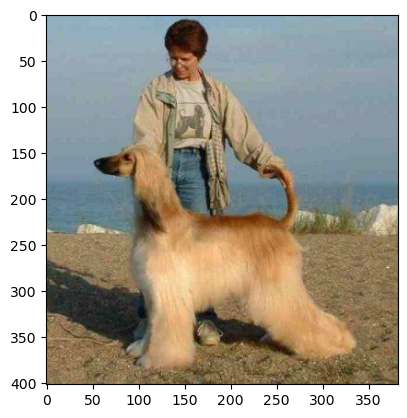

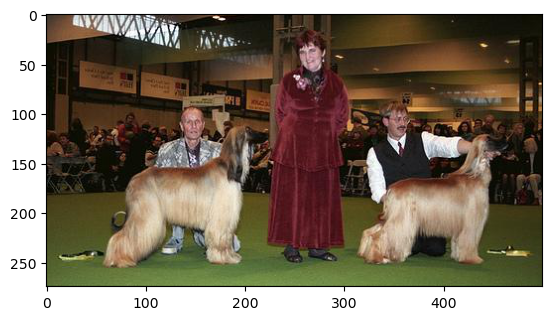

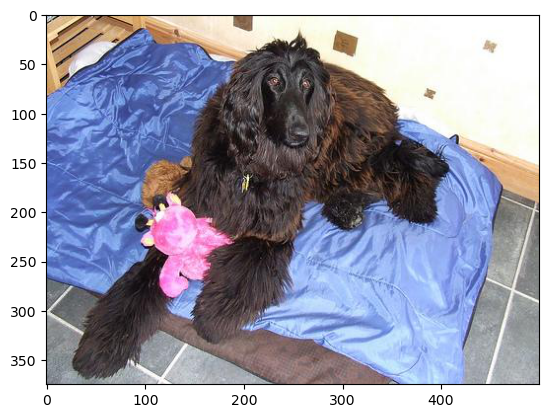

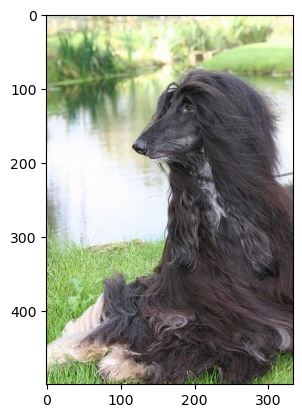

photo_path
0  ./data/raw_data/Images/n02085936-Maltese_dog/n...

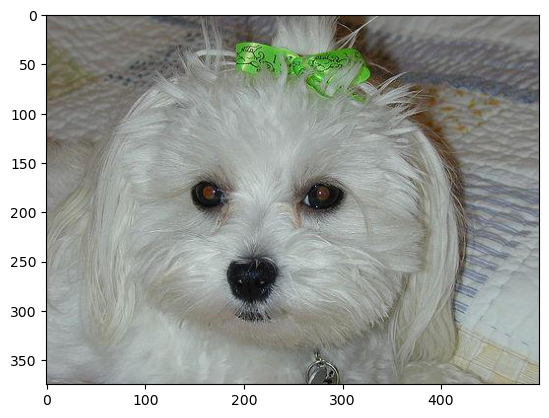

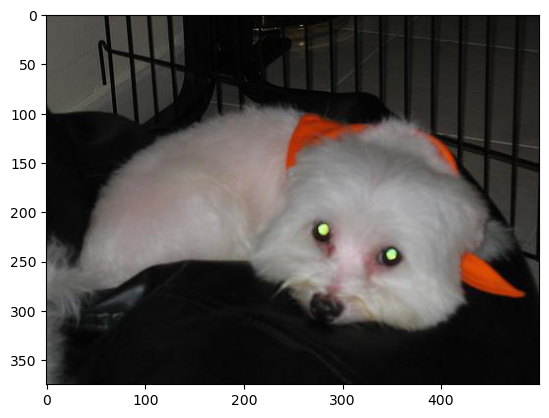

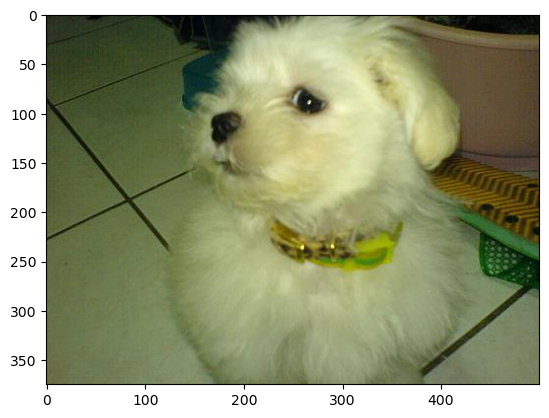

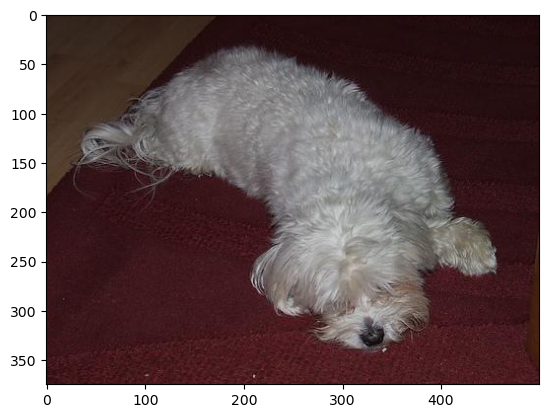

photo_path
0  ./data/raw_data/Images/n02092002-Scottish_deer...

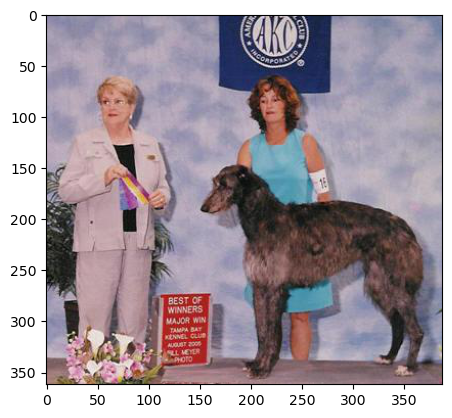

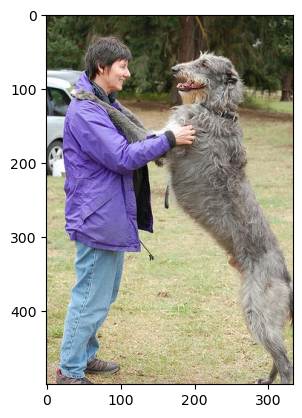

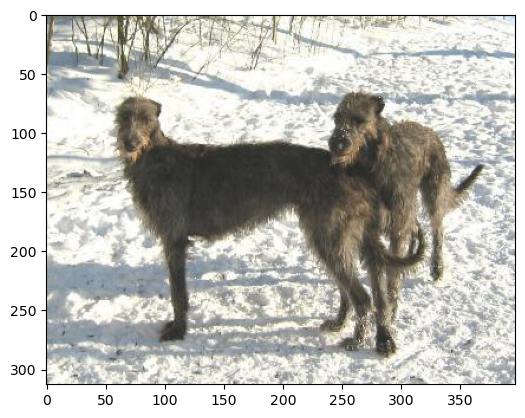

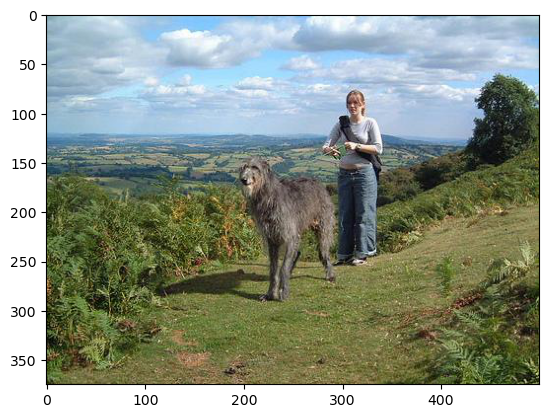

In [16]:
# show a few random pictures (4) for each breed

for i in range(nb_classes):
    subset = data.loc[data['target'] == i, ['photo_path']]
    # Shuffle the subset
    shuffled_subset = subset.sample(n=4).reset_index(drop=True)
    display(shuffled_subset.head(1))

    for j in range(shuffled_subset.shape[0]):
        image = imread(shuffled_subset['photo_path'][j])
        plt.imshow(image)
        plt.show()


### 1.9 taille des images


In [17]:
# ajouter infos pour .describe() : largeur, hauteur

def get_width(address):
    img = Image.open(address)
    width, height = img.size
    return width

def get_height(address):
    img = Image.open(address)
    width, height = img.size
    return height

data['width'] = data['photo_path'].apply(get_width)
data['height'] = data['photo_path'].apply(get_height)

data.head()


photo_path        breed  target  \
0  ./data/raw_data/Images/n02085936-Maltese_dog/n...  maltese_dog       1   
1  ./data/raw_data/Images/n02085936-Maltese_dog/n...  maltese_dog       1   
2  ./data/raw_data/Images/n02085936-Maltese_dog/n...  maltese_dog       1   
3  ./data/raw_data/Images/n02085936-Maltese_dog/n...  maltese_dog       1   
4  ./data/raw_data/Images/n02085936-Maltese_dog/n...  maltese_dog       1   

   width  height  
0    500     333  
1    500     375  
2    400     500  
3    500     333  
4    500     375

In [18]:
data[['width', 'height']].describe()


width       height
count   723.000000   723.000000
mean    448.680498   415.004149
std     110.799319    95.457471
min     193.000000   180.000000
25%     375.000000   343.500000
50%     500.000000   375.000000
75%     500.000000   500.000000
max    1448.000000  1208.000000

In [19]:
# check pixel values ? (pour une éventuelle normalisation)
# 0-255 pour .jpg


## 1 Etude de faisabilité, analyse


### 1.1 modèle pré-entraîné


In [20]:
base_model = VGG16()
model = Model(inputs=base_model.inputs, outputs=base_model.layers[-2].output)

print(model.summary())


2024-03-24 10:55:28.629695: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

### 1.2 features


In [23]:
images_features = []

for image_file in data["photo_path"] :
    image = load_img(image_file, target_size=(224, 224))
    image = img_to_array(image)
    image = np.expand_dims(image, axis=0)
    image = preprocess_input(image)
    images_features.append(model.predict(image, verbose=0)[0]) # predict from pretrained model

images_features = np.asarray(images_features)
images_features.shape


(723, 4096)

### 1.3 Réduction dim


In [77]:
# PCA
# equivalent du scaling ici : preprocess_input(image)

pca = decomposition.PCA(n_components=0.99)
feat_pca= pca.fit_transform(images_features)

print(feat_pca.shape)

# dimention divisée par 10 (presque), en conservant 99% de la variance !


(578, 4096)
(578, 468)


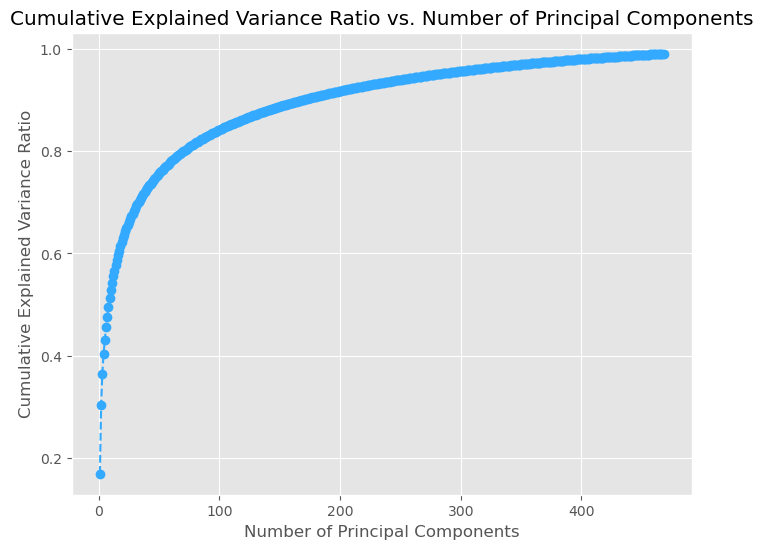

In [78]:
# Plot explained variance ratio
plt.figure(figsize=(8, 6))
plt.plot(range(1, pca.n_components_ + 1), pca.explained_variance_ratio_.cumsum(), marker='o', linestyle='--', color='#3af')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Cumulative Explained Variance Ratio vs. Number of Principal Components')
plt.grid(True)
plt.show()

# Pourquoi on a besoin du tsne pour la visu : en 2D ou même en 3D, les 3 premiers vecteurs propres
# # fournis par la PCA ne captent "que" (environ) un tiers de l'information.
# Ce qu'on verrait serait très déformé par les projections successives de la PCA.
# tester ?


In [79]:
# t-sne

tsne = manifold.TSNE(n_components=2, perplexity=30, n_iter=2000, init='random', random_state=6)
X_tsne = tsne.fit_transform(feat_pca)


/tmp/ipykernel_481633/3711302779.py:5: UserWarning: The palette list has more values (4) than needed (3), which may not be intended.
  sns.scatterplot(


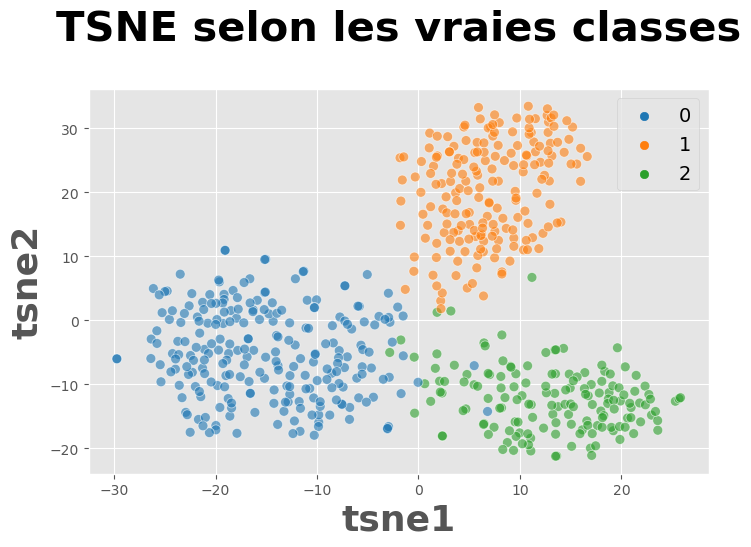

In [80]:
df_tsne = pd.DataFrame(X_tsne, columns=['tsne1', 'tsne2'])
df_tsne["class"] = data_df["target"]

plt.figure(figsize=(8,5))
sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="class",
    palette=sns.color_palette('tab10', n_colors=4), s=50, alpha=0.6,
    data=df_tsne,
    legend="brief")

plt.title('TSNE selon les vraies classes', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 14})

plt.show()


In [81]:
cls = cluster.KMeans(n_clusters=nb_classes, n_init=100)
cls.fit(X_tsne)


KMeans(n_clusters=3, n_init=100)

/tmp/ipykernel_481633/3373487736.py:4: UserWarning: The palette list has more values (4) than needed (3), which may not be intended.
  sns.scatterplot(


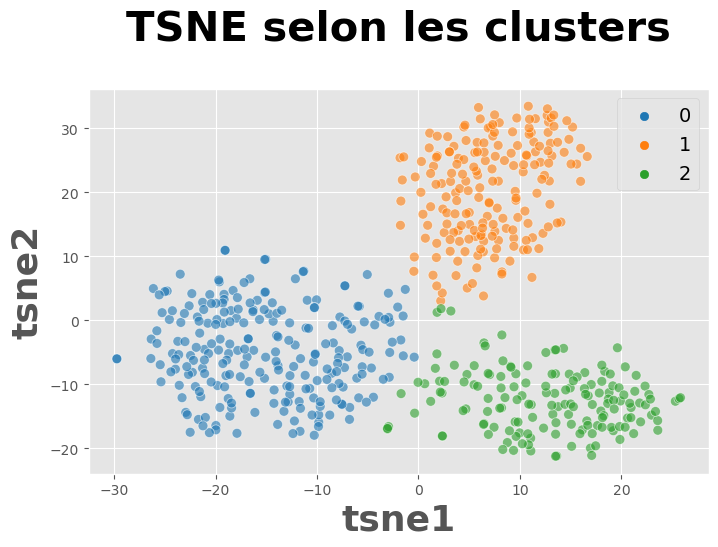

ARI :  0.9348260990572881


In [82]:
df_tsne["cluster"] = cls.labels_

plt.figure(figsize=(8,5))
sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="cluster",
    palette=sns.color_palette('tab10', n_colors=4), s=50, alpha=0.6,
    data=df_tsne,
    legend="brief")

plt.title('TSNE selon les clusters', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 14})

plt.show()

labels = data_df["breed"]
print("ARI : ", metrics.adjusted_rand_score(labels, cls.labels_))


In [83]:
# Faisabilité ok

### images mal classées


nb de photos (en tout) : 578
13
[30, 73, 102, 149, 253, 287, 341, 361, 393, 428, 459, 481, 561]
index : 30


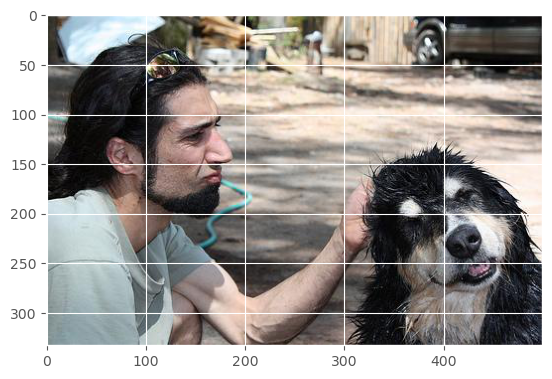

True class : 2, ./data/raw_data/Images/n02108551-Tibetan_mastiff
(wrongly) predicted class : 0.0
index : 73


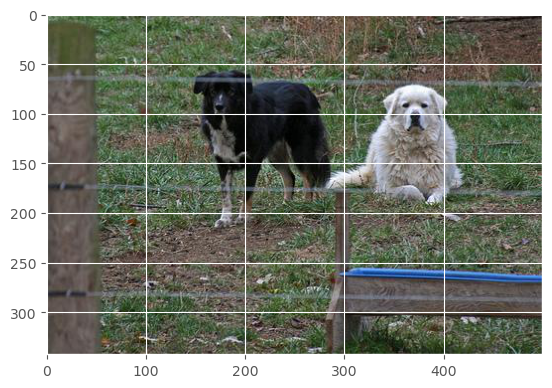

True class : 2, ./data/raw_data/Images/n02108551-Tibetan_mastiff
(wrongly) predicted class : 0.0
index : 102


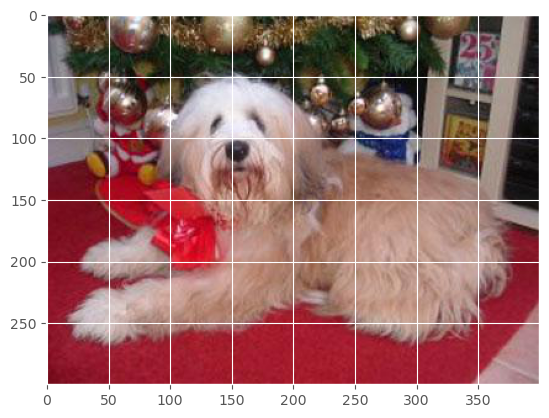

True class : 2, ./data/raw_data/Images/n02108551-Tibetan_mastiff
(wrongly) predicted class : 0.0
index : 149


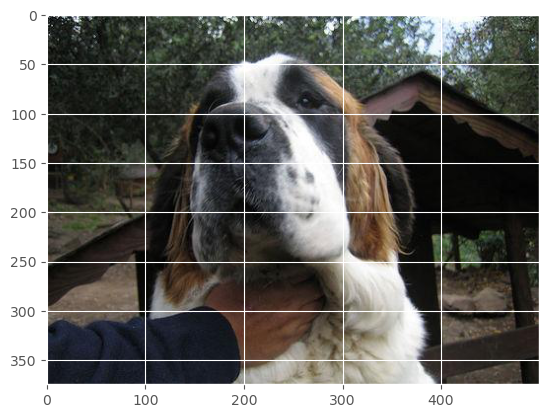

True class : 2, ./data/raw_data/Images/n02108551-Tibetan_mastiff
(wrongly) predicted class : 1.0
index : 253


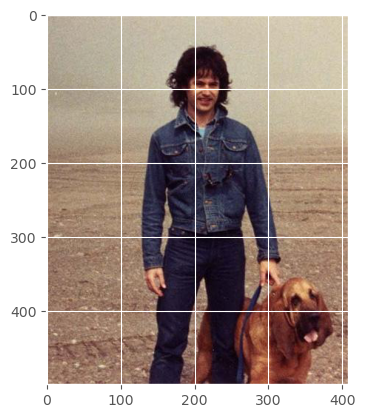

True class : 1, ./data/raw_data/Images/n02088466-bloodhound
(wrongly) predicted class : 0.0
index : 287


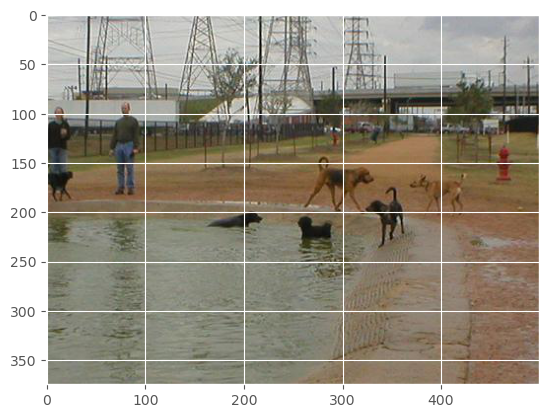

True class : 1, ./data/raw_data/Images/n02088466-bloodhound
(wrongly) predicted class : 2.0
index : 341


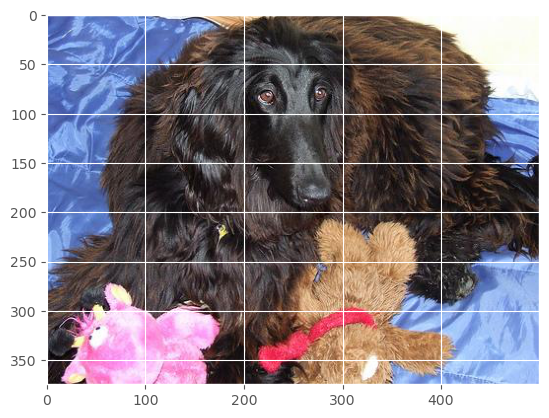

True class : 0, ./data/raw_data/Images/n02088094-Afghan_hound
(wrongly) predicted class : 2.0
index : 361


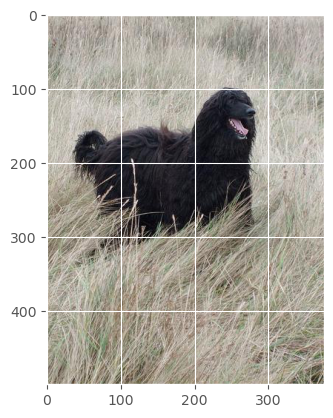

True class : 0, ./data/raw_data/Images/n02088094-Afghan_hound
(wrongly) predicted class : 2.0
index : 393


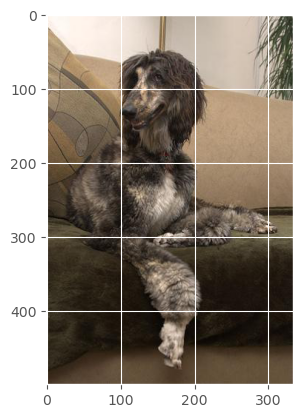

True class : 0, ./data/raw_data/Images/n02088094-Afghan_hound
(wrongly) predicted class : 2.0
index : 428


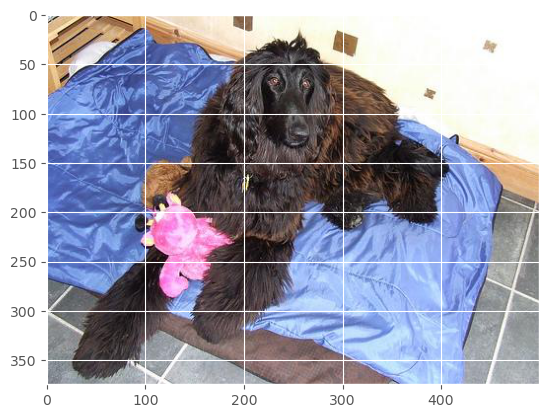

True class : 0, ./data/raw_data/Images/n02088094-Afghan_hound
(wrongly) predicted class : 2.0
index : 459


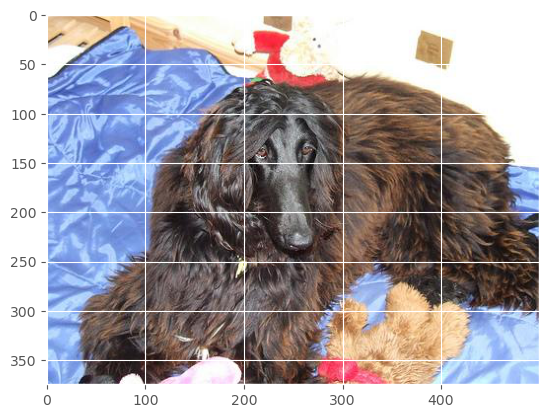

True class : 0, ./data/raw_data/Images/n02088094-Afghan_hound
(wrongly) predicted class : 2.0
index : 481


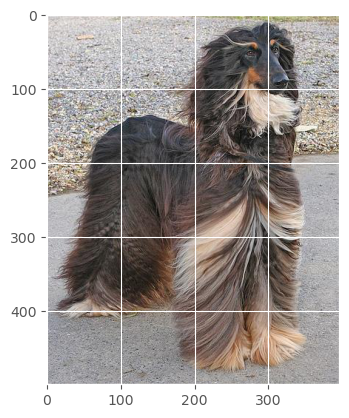

True class : 0, ./data/raw_data/Images/n02088094-Afghan_hound
(wrongly) predicted class : 2.0
index : 561


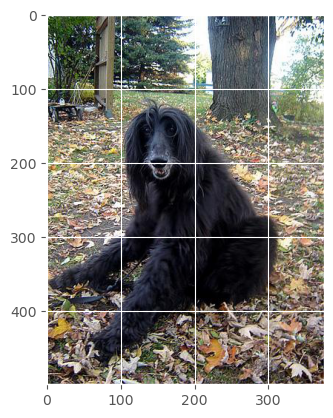

True class : 0, ./data/raw_data/Images/n02088094-Afghan_hound
(wrongly) predicted class : 2.0


In [84]:
#

print(f"nb de photos (en tout) : {data_df['photo_path'].shape[0]}")

list_bad_predictions = [i for i in range(len(data_df["photo_path"])) \
                if (data_df.iloc[i]['target'] != df_tsne.iloc[i]['cluster'])]

print(len(list_bad_predictions))
print(list_bad_predictions)

for i in list_bad_predictions:
    print(f'index : {i}')
    # pic
    image = imread(data_df['photo_path'][i])
    plt.imshow(image)
    plt.show()
    # real class
    print(f"True class : {data_df.iloc[i]['target']}, {data_df.iloc[i]['breed']}")
    # (wrong) prediction
    print(f"(wrongly) predicted class : {df_tsne.iloc[i]['cluster']}")


In [85]:
# 13 erreurs / 578 photos, impressionnant !

# 2 types d'erreurs :

# 4 mastiffs tibétains ont été mal classifiés : 3 en chien de Saint-Hubert (bloodhound),
# 1 en lévrier afghan.
# 9 lévriers afghans mal classifiés, tous confondus avec des mastiffs.


### Analyse par classes


In [86]:
labels = data_df["target"]

conf_mat = metrics.confusion_matrix(labels, cls.labels_)

print(conf_mat) # on retrouve nos 13 erreurs, en dehors de la trace (diagonale True positifs)


[[232   0   7]
 [  1 185   1]
 [  3   1 148]]


In [87]:
def conf_mat_transform(y_true,y_pred) :
    conf_mat = metrics.confusion_matrix(y_true,y_pred)

    corresp = np.argmax(conf_mat, axis=0)
    print ("Correspondance des clusters : ", corresp)
    # y_pred_transform = np.apply_along_axis(correspond_fct, 1, y_pred)
    labels = pd.Series(y_true, name="y_true").to_frame()
    labels['y_pred'] = y_pred
    labels['y_pred_transform'] = labels['y_pred'].apply(lambda x : corresp[x])

    return labels['y_pred_transform']


In [88]:
cls_labels_transform = conf_mat_transform(labels, cls.labels_)
conf_mat = metrics.confusion_matrix(labels, cls_labels_transform) # diff ??
print(conf_mat, '\n')

print(metrics.classification_report(labels, cls_labels_transform))


Correspondance des clusters :  [0 1 2]
[[232   0   7]
 [  1 185   1]
 [  3   1 148]] 

              precision    recall  f1-score   support

           0       0.98      0.97      0.98       239
           1       0.99      0.99      0.99       187
           2       0.95      0.97      0.96       152

    accuracy                           0.98       578
   macro avg       0.98      0.98      0.98       578
weighted avg       0.98      0.98      0.98       578



<Axes: >

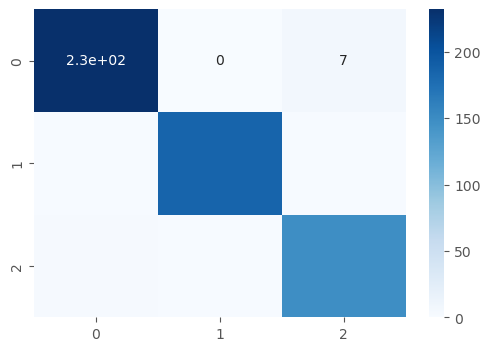

In [89]:
df_cm = pd.DataFrame(conf_mat, index = [label for label in range(nb_classes)],
                  columns = [i for i in "012"])
plt.figure(figsize = (6,4))
sns.heatmap(df_cm, annot=True, cmap="Blues")

# valeurs manquantes ??


In [ ]:
#

## 2 Prétraitement


In [ ]:
# Dépend du modèle


# Concerne seulement notre modèle perso (ntbk 2),
# les modèles importés pour le transfer learning (ntbk 3) ont leur propre preprocessing
# (fonction preprocess_input())

# models possible -> "inspiration" :

# "historique" : AlexNet
# le + simple, five convolutional layers, followed by three fully connected layers

# vgg16 et 19
# restent assez simples (/nb de layers, mais entre guillemets car le cours précise qu'ils faut déjà
# + d'un mois pour les entrainer)

# GoogLeNet, also known as Inception v1 : 22 layers
# "introduced the Inception module, which allows the network to learn features at multiple scales.
# The Inception module consists of parallel convolutional layers with different filter sizes,
# which are concatenated to form the output of the module. GoogLeNet also introduced the use of
# global average pooling, which reduces the number of parameters in the network and helps
# prevent overfitting. " (https://jonascleveland.com/best-image-classification-models/)


# ensuite on passe à 55 couches (MobileNet), puis 81 (Xception) et + !
# (jusqu'à 533 pour NASNetLarge)

# Parmi ces modèles + profond : tester un ResNet (microsoft), DenseNet (facebook)

# OC : "tels que par exemple VGG16, ResNet50, Inception V3 ou Inception ResNetV2"


# envie de tester en + ds quelle mesure la couleur "aide" les modèles,
# en modifiant preprocessing(-> black & white) + 1ere layer
# puis comparer scores
